In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import configparser
import os
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.analysis_utils as analysis
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import scipy
from IPython.display import Image, display_png

%matplotlib inline

28-ID - VKB Pitch Motor Resolution: 2e-05 deg
Qt5Agg: unable to import specified backend (or its dependency); no plots


**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.
Traceback (most recent call last):
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot.py", line 57, in uti_plot_init
    _backend = uti_plot_matplotlib.Backend(backend, fname_format)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot_matplotlib.py", line 27, in __init__
    backend = self._init_ipython(backend)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot_matplotlib.py", line 724, in _init_ipython
    get_ipython().magic('matplotlib ' + b)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.

In [3]:
exp_type = 'peak_fwhm_nlpi'

In [4]:
#base_dir = Path(aps.__file__).parents[1]
#autoalign_dir = base_dir / f'work_directory/28-ID/AI/autoalignment/'
autoalign_dir = Path("/Users/skandel/Library/CloudStorage/Box-Box/Beamtime_28ID_Nov2022/AI/autofocusing/")
data_base_dir = autoalign_dir / exp_type / 'all_motors_coma'
print(f'data base dir exists {data_base_dir.exists()}')


data base dir exists True


In [5]:
!ls {data_base_dir}

Screen Shot 2022-11-21 at 6.46.08 PM.png
peak_fwhm_nlpi_moo_100_2022-11-21_images
peak_fwhm_nlpi_moo_100_2022-11-21_steps
peak_fwhm_nlpi_moo_autofocusing.ini
peak_fwhm_nlpi_moo_optimization_final_101_2022-11-21_18:31.gz
slits_078x0.12.png
slits_078x0.36.png


### peak_fwhm_150_2022-11-21

In [6]:
!ls {data_base_dir}

Screen Shot 2022-11-21 at 6.46.08 PM.png
peak_fwhm_nlpi_moo_100_2022-11-21_images
peak_fwhm_nlpi_moo_100_2022-11-21_steps
peak_fwhm_nlpi_moo_autofocusing.ini
peak_fwhm_nlpi_moo_optimization_final_101_2022-11-21_18:31.gz
slits_078x0.12.png
slits_078x0.36.png


In [7]:
log_file = Path(data_base_dir / 'peak_fwhm_nlpi_moo_optimization_final_101_2022-11-21_18:31.gz')
log_file.exists()

True

In [8]:
hist_dir = Path(data_base_dir / 'peak_fwhm_nlpi_moo_100_2022-11-21_steps')
hist_dir.exists()

True

In [9]:
study = analysis.create_study_from_trials(log_file, n_objectives=3)

[I 2022-11-23 17:27:44,146] A new study created in memory with name: no-name-c8645dd8-b1ca-4fba-8025-bbc78e16df5e


Assuming minimization for all objectives.


In [10]:
n_steps = len(study.trials)

In [11]:
hists = analysis.load_histograms_from_files(n_steps, hist_dir, extension='gz')

Trial values: peak_distance 8.078e-02 fwhm 1.404e+00 nlpi -9.772e+00
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.401485058027504, 'h_fwhm': 1.404000000000094, 'h_centroid': -0.0017463270150050725, 'h_peak': -0.07055766558591944, 'v_sigma': 0.47064040439042354, 'v_fwhm': 0.006502540054709183, 'v_centroid': 0.006134391857760907, 'v_peak': -0.03934036733098869, 'integral_intensity': 268.23379054618596, 'peak_intensity': 17541.2, 'gaussian_fit': {}}}


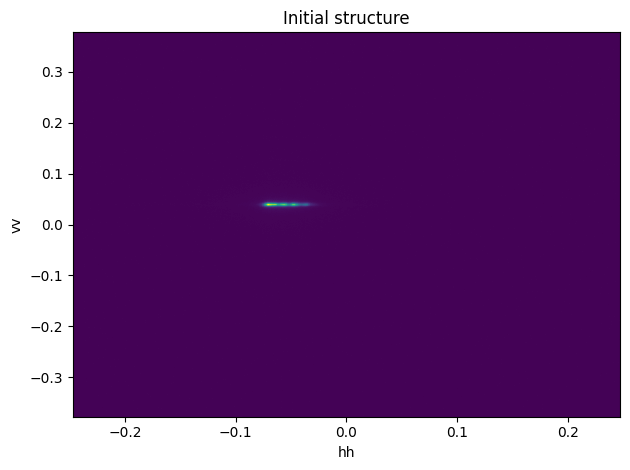

In [12]:
print(f"Trial values: peak_distance {study.trials[0].values[0]:4.3e} fwhm {study.trials[0].values[1]:4.3e} " +
     f"nlpi {study.trials[0].values[2]:4.3e}")
print("Trial dw:")
print(study.trials[0].user_attrs["dw"].__dict__)


plt.pcolormesh(hists[0].hh[700:-700], hists[0].vv[700:-700], hists[0].data_2D[700:-700,700:-700].T)
plt.xlabel('hh')
plt.ylabel('vv')
plt.title("Initial structure")
plt.tight_layout()
plt.show()

In [13]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

In [14]:
print(n_doms)
print(nash_trial.number, nash_trial.values)
print(nash_trial.user_attrs["dw"].__dict__)
print("Actual fwhm (not with reference)", opt_common._get_fwhm_from_dw(nash_trial.user_attrs["dw"]))

[75, 19, 94, 90, 51]
10 [0.013366714725420488, 1.1061743440157121, -10.462209701538086]
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.4015682687156022, 'h_fwhm': 1.1061621120890042, 'h_centroid': -0.000659612372441748, 'h_peak': -0.012680870773506308, 'v_sigma': 0.4707828989055628, 'v_fwhm': 0.005202032043767346, 'v_centroid': 0.005484774901177436, 'v_peak': 0.004226651035560713, 'integral_intensity': 268.11322445422485, 'peak_intensity': 34968.75, 'gaussian_fit': {}}}
Actual fwhm (not with reference) 1.1061743440157121


Trial number 2
Trial values: peak_distance 8.001e-02 fwhm 6.016e-01
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.4014635151765894, 'h_fwhm': 0.6015284854099523, 'h_centroid': -0.0018713164604999832, 'h_peak': -0.07966188050023161, 'v_sigma': 0.4706640071846351, 'v_fwhm': 0.007803048065651019, 'v_centroid': 0.005477311809855445, 'v_peak': 0.007477921062915084, 'integral_intensity': 268.31064973836766, 'peak_intensity': 27315.0, 'gaussian_fit': {}}}
Actual fwhm 0.6015790939840796


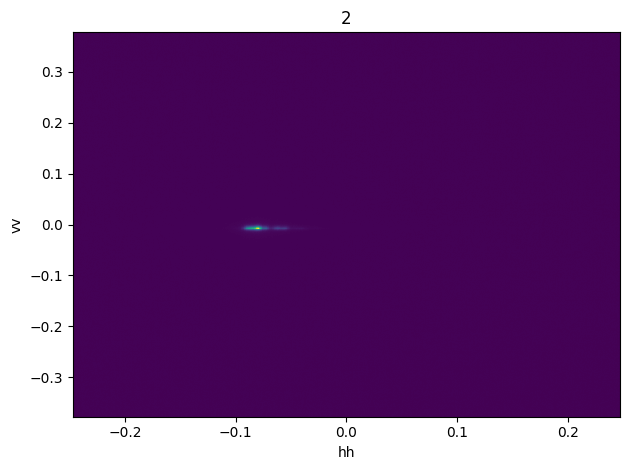

Trial number 7
Trial values: peak_distance 2.055e-01 fwhm 4.628e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.4017899275188471, 'h_fwhm': 0.013656322371469187, 'h_centroid': 0.0009079597562492991, 'h_peak': 0.11998054654932833, 'v_sigma': 0.47113395023883486, 'v_fwhm': 0.04421727237202244, 'v_centroid': 0.008034933090316915, 'v_peak': -0.16679015240328263, 'integral_intensity': 268.08976075013277, 'peak_intensity': 18217.111, 'gaussian_fit': {}}}
Actual fwhm 0.04627809759200468


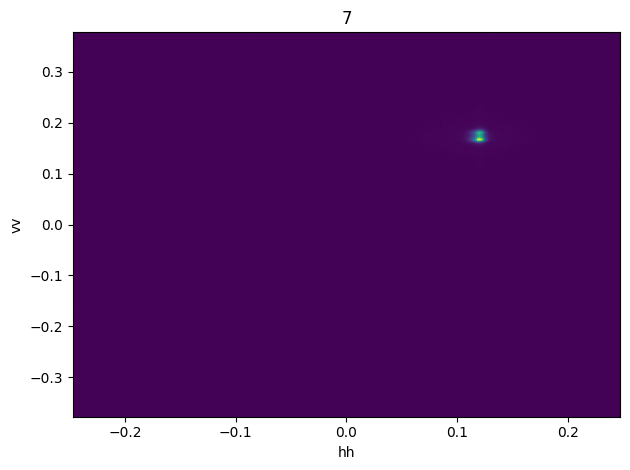

Trial number 10
Trial values: peak_distance 1.337e-02 fwhm 1.106e+00
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.4015682687156022, 'h_fwhm': 1.1061621120890042, 'h_centroid': -0.000659612372441748, 'h_peak': -0.012680870773506308, 'v_sigma': 0.4707828989055628, 'v_fwhm': 0.005202032043767346, 'v_centroid': 0.005484774901177436, 'v_peak': 0.004226651035560713, 'integral_intensity': 268.11322445422485, 'peak_intensity': 34968.75, 'gaussian_fit': {}}}
Actual fwhm 1.1061743440157121


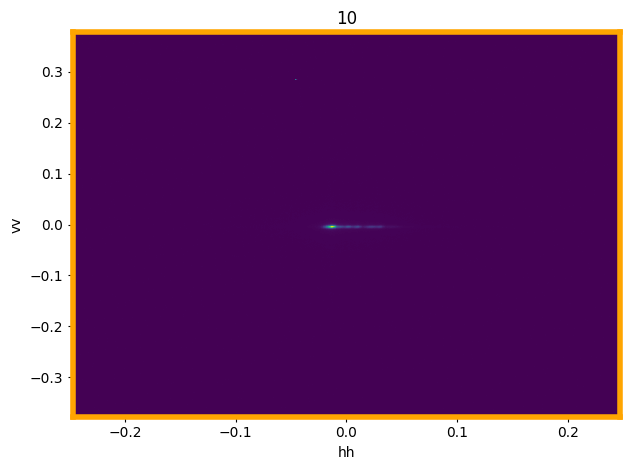

Trial number 13
Trial values: peak_distance 9.568e-03 fwhm 4.197e-01
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.4015845777835324, 'h_fwhm': 0.41944418712369647, 'h_centroid': -0.0006085651038972573, 'h_peak': -0.0016257526632700889, 'v_sigma': 0.4708037963479019, 'v_fwhm': 0.015606096131302039, 'v_centroid': 0.005725907518988743, 'v_peak': -0.009428683079327914, 'integral_intensity': 268.11008513510757, 'peak_intensity': 17398.916, 'gaussian_fit': {}}}
Actual fwhm 0.419734411679955


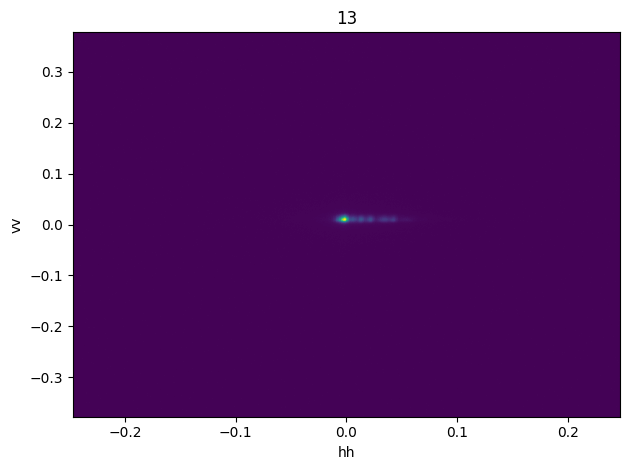

Trial number 16
Trial values: peak_distance 2.476e-03 fwhm 1.404e+00
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.40167248528570104, 'h_fwhm': 1.404000000000094, 'h_centroid': -0.0006841731177621435, 'h_peak': 0.0009754515979620237, 'v_sigma': 0.4707916947129939, 'v_fwhm': 0.020157874169598466, 'v_centroid': 0.005590158068646628, 'v_peak': -0.0022758890191481784, 'integral_intensity': 268.14740514426904, 'peak_intensity': 12473.429, 'gaussian_fit': {}}}
Actual fwhm 1.4041447004818632


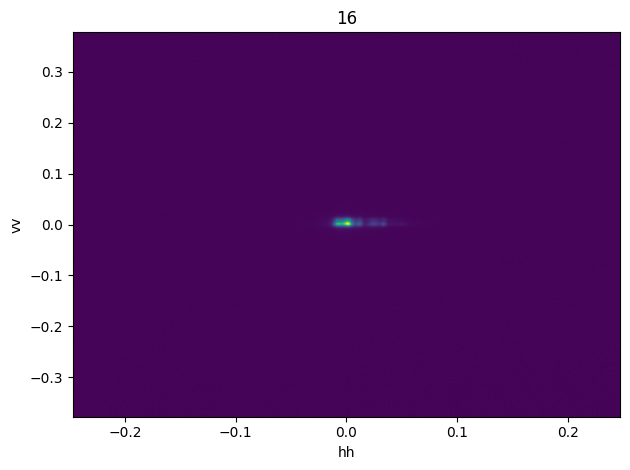

CA client library is unable to contact CA repeater after 50 tries.
Silence this message by starting a CA repeater daemon
or by calling ca_pend_event() and or ca_poll() more often.


In [15]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: peak_distance {t.values[0]:4.3e} fwhm {t.values[1]:4.3e}")
    print("Trial dw:")
    print(t.user_attrs["dw"].__dict__)
    print("Actual fwhm", opt_common._get_fwhm_from_dw(t.user_attrs["dw"]))
    hist = hists[t.number]
    plt.pcolormesh(hist.hh[700:-700], hist.vv[700:-700], hist.data_2D[700:-700,700:-700].T)
    if t.number == nash_trial.number:
        for axis in ['top','bottom','left','right']:
            plt.gca().spines[axis].set_linewidth(4)
            plt.gca().spines[axis].set_color('orange')
    plt.xlabel('hh')
    plt.ylabel('vv')
    plt.title(t.number)
    plt.tight_layout()
    plt.show()

In [16]:
study.best_trials[0].values

[0.08001208976308749, 0.6015790939840796, -10.215190887451172]

In [17]:
pareto_df = analysis.get_pareto_dataframe_from_study(study, ['peak_distance', 'delta_fwhm', 'nlpi'])

In [18]:
pareto_df

,number,peak_distance,delta_fwhm,nlpi,h_peak,v_peak,h_fwhm,v_fwhm,peak_intensity
2,2,0.080012,0.601579,-10.215191,-0.079662,0.007478,0.601528,0.007803,27315.000000
7,7,0.205461,0.046278,-9.810117,0.119981,-0.166790,0.013656,0.044217,18217.111328
10,10,0.013367,1.106174,-10.462210,-0.012681,0.004227,1.106162,0.005202,34968.750000
13,13,0.009568,0.419734,-9.764163,-0.001626,-0.009429,0.419444,0.015606,17398.916016
16,16,0.002476,1.404145,-9.431356,0.000975,-0.002276,1.404000,0.020158,12473.428711


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_12828/2375896861.py:3: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(study, target_names=["peak_distance", "delta_fwhm", "nlpi"], include_dominated_trials=False)


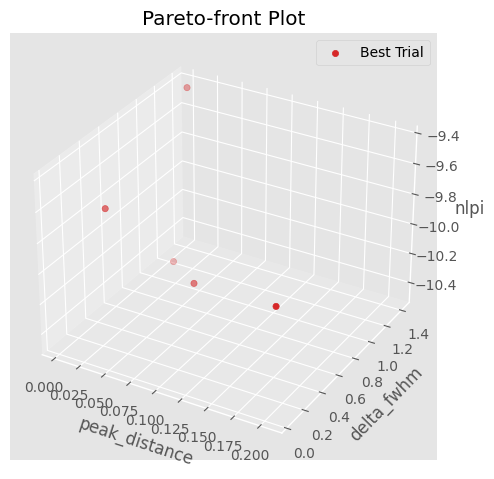

In [19]:
# Generating the pareto front for the multiobjective optimization

optuna.visualization.matplotlib.plot_pareto_front(study, target_names=["peak_distance", "delta_fwhm", "nlpi"], include_dominated_trials=False)
#plt.scatter(*nash_trial.values, color='orange', label='Nash')
plt.legend(loc='best')
plt.tight_layout()

# plt.savefig(...) to save the image
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_12828/320309324.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="peak_distance")


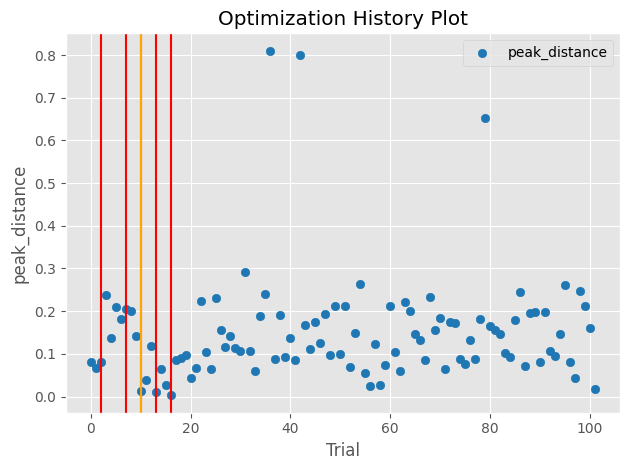

In [20]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="peak_distance")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='orange')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_12828/1279663034.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[1], target_name="delta_fwhm")


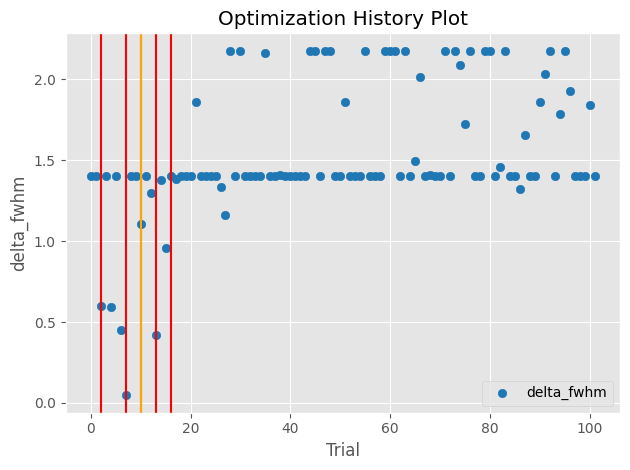

In [21]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[1], target_name="delta_fwhm")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='orange')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_12828/3199083138.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[2], target_name="nlpi")


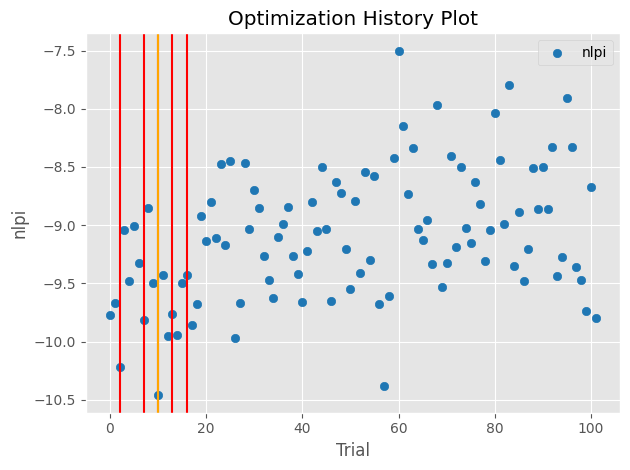

In [22]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[2], target_name="nlpi")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='orange')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

#### The remaining part is just testing how lwsi with thresholding performs in selecting the structures. This is for my own satisfaction. - SK

In [23]:
isums = []
wsums_no_thres = []
wsums_thres = []
for h in hists:
    isum1, wsum1 = analysis.calculate_weighted_sum(h, threshold=0)
    isum2, wsum2 = analysis.calculate_weighted_sum(h)
    isums.append((isum1, isum2))
    wsums_no_thres.append(wsum1)
    wsums_thres.append(wsum2)
isums = np.array(isums)
wsums_no_thres = np.array(wsums_no_thres)
wsums_thres = np.array(wsums_thres)
                      

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_12828/214102518.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_no_thres[t.number]),


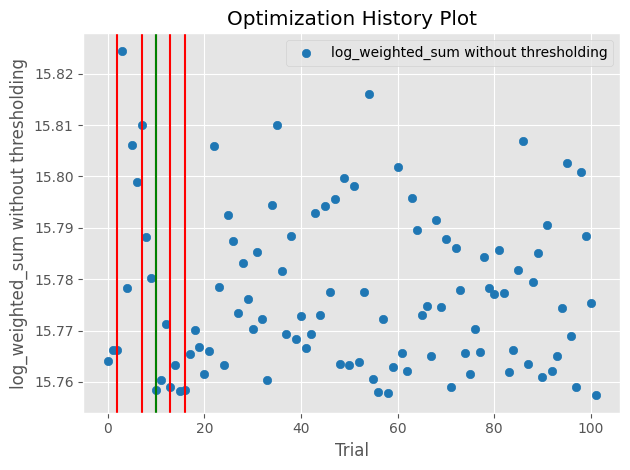

In [24]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_no_thres[t.number]),
                                                          target_name="log_weighted_sum without thresholding")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_12828/2958963105.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_thres[t.number]),


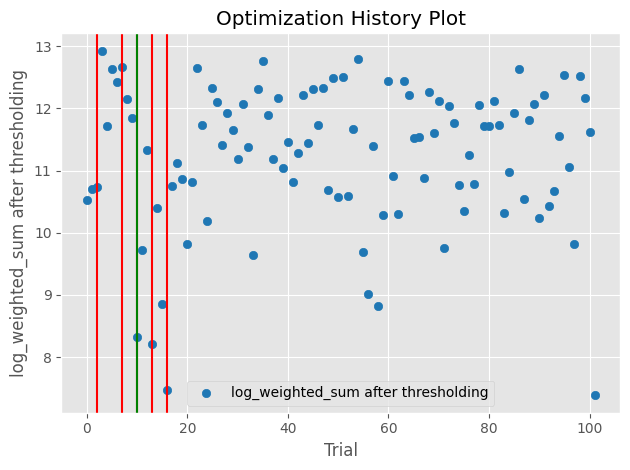

In [25]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_thres[t.number]),
                                                          target_name="log_weighted_sum after thresholding")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [26]:
test_val_fns = [lambda t: t.values[0], lambda t: t.values[2], lambda t: np.log(wsums_thres[t.number])]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, study.directions, values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1, 1], test_val_fns)
print(np.argmax(domins))

10


10 [0.013366714725420488, -10.462209701538086, 8.326755106873964]


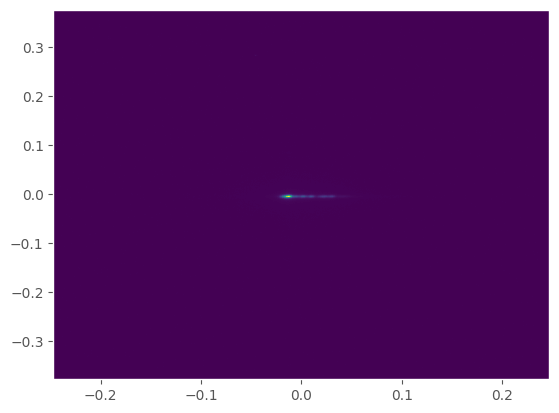

13 [0.009567817741394027, -9.76416301727295, 8.211130601529655]


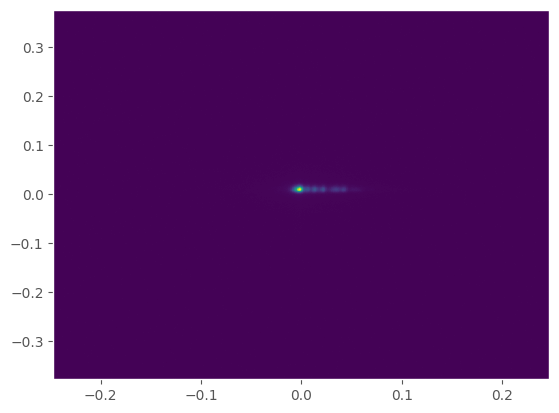

16 [0.0024761212909399093, -9.431356430053711, 7.467094804943765]


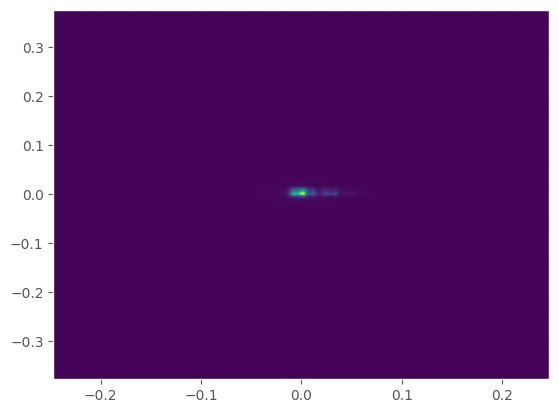

101 [0.017909766650565845, -9.794880867004395, 7.381433088986161]


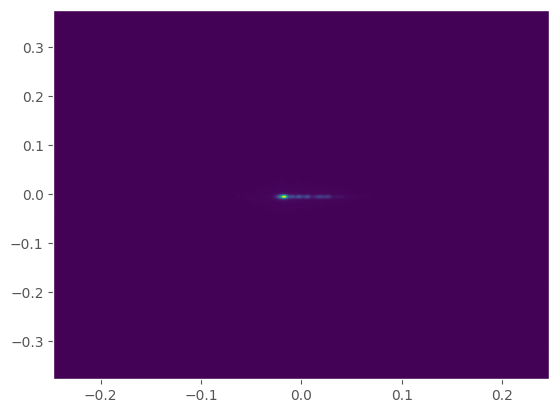

In [27]:
for t in test_pareto:
    print(t.number, test_values[t.number])
    hdata = hists[t.number]
    
    plt.pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T)
    plt.show()

In [28]:
test_val_fns = [lambda t: t.values[0], lambda t: opt_common._get_fwhm_from_dw(t.user_attrs['dw']), lambda t: np.log(wsums_thres[t.number])]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1, 1, 1], values_fns=test_val_fns)

domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1, 1], test_val_fns)
print(np.argmax(domins), domins[np.argmax(domins)])

13 98
